In [1]:
from PIL import Image
import os
import pathlib
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sk_shuffle
import time
import os

import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import glob2
import pdb
import ipdb

In [2]:

SEED = 42


labels_dict = {'1':1, '2':2, '3':3, '4':4, '5':5,
               '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11, '12':12, '13':13, '14':14, '15':15,
               '16':16, '17':17, '18':18, '19':19, '20':20,
               '21':21, '22':22, '23':23, '24':24, '25':25,
               '26':26, '27':27, '28':28, '29':29, '30':30,
               '31':31, '32':32, 'a':33, 'b':34, 'c':35, 'd':36,
               'e':37, 'f':38, 'g':39, 'h':40, 'i':41, 'j':42, 'k':43,
               'l':44, 'm':45, 'n':46, 'o':47, 'p':48, 'q':49, 'r':50, 's':51, 't':52,
               'conecut':53, 'caries':54, 'caries2':54,'caries3':54,'crown':55, 'bridge':56,
               'gutta-percha':57, 'pin':58, 'post':59, 'buildup':60, 'calculus':61, 'sealer':62,
               'cement':63, 'bracket':64, 'retainer':65, 'instrument':66, 'implant':67, 'screw':68,
               'veneer':69, 'silver-point':70, 'space-maintainer':71, 'core':72, 'base':73,
               'temporary-filling':74, 'medicament':75, 'framework':76, 'liner':77, 'onlay-composite':78,
               'onlay-metal':79, 'onlay-ceramic':80, 'inlay-ceramic':81, 'inlay-composite':82, 'inlay-metal':83,
               'filling-composite':84, 'filling-glass':85, 'filling-metal':86}

reverse_labels_dict = {v: k for k, v in labels_dict.items()}

labels_dict_no_baby = {'1':1, '2':2, '3':3, '4':4, '5':5,
               '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11, '12':12, '13':13, '14':14, '15':15,
               '16':16, '17':17, '18':18, '19':19, '20':20,
               '21':21, '22':22, '23':23, '24':24, '25':25,
               '26':26, '27':27, '28':28, '29':29, '30':30,
               '31':31, '32':32, 'conecut':33, 'caries':34, 'caries2':34,'caries3':34}
regions_dict_all = {'Anterior1MandibleB':0,
               'Anterior2MaxillaL':1,
               'Anterior2MaxillaR':2,
               'Anterior3MandibleL':3,
               'Anterior3MandibleR':4,
               'Anterior3MaxillaL':5,
               'Anterior3MaxillaR':6,
               'Molar3JawregionL':7,
               'Molar3JawregionR':8,
               'Molar3MandibleL':9,
               'Molar3MandibleR':10,
               'Molar3MaxillaL':11,
               'Molar3MaxillaR':12,
               'Anterior1MandibleL':13,
               'Premolar2JawregionR':14,
               'Premolar2MandibleR':15,
               'Premolar2MaxillaL':16,
               'Premolar2MaxillaR':17,
               'Anterior1MaxillaB':18,
               'Premolar2MandibleL':19,
               'Premolar2JawregionL':20,
               'Anterior1MaxillaR':21,
               'Anterior1MaxillaL':22,
               'Anterior2MaxillaB':23,
               'Anterior2MandibleL':24,
               'Anterior1MandibleR':25}

regions_dict_standard = {'Anterior2MaxillaR':0,
                         'Anterior3MaxillaR':1,
                         'Anterior1MandibleB':2,
                         'Molar3MandibleR':3,
                         'Molar3MaxillaL':4,
                         'Anterior2MaxillaL':5,
                         'Anterior3MaxillaL':6,
                         'Molar3MaxillaR':7,
                         'Anterior3MandibleL':8,
                         'Premolar2MaxillaL':9,
                         'Premolar2MandibleR':10,
                         'Premolar2MandibleL':11,
                         'Molar3JawregionL':12,
                         'Anterior3MandibleR':13,
                         'Molar3JawregionR':14,
                         'Premolar2JawregionL':15,
                         'Premolar2JawregionR':16,
                         'Premolar2MaxillaR':17,
                         'Anterior1MaxillaB':18,
                         'Molar3MandibleL':19}


In [3]:
tooth_dict = {'1':1, '2':2, '3':3, '4':4, '5':5,
               '6':6, '7':7, '8':8, '9':9, '10':10,
               '11':11, '12':12, '13':13, '14':14, '15':15,
               '16':16, '17':17, '18':18, '19':19, '20':20,
               '21':21, '22':22, '23':23, '24':24, '25':25,
               '26':26, '27':27, '28':28, '29':29, '30':30,
               '31':31, '32':32, 'a':33, 'b':34, 'c':35, 'd':36,
               'e':37, 'f':38, 'g':39, 'h':40, 'i':41, 'j':42, 'k':43,
               'l':44, 'm':45, 'n':46, 'o':47, 'p':48, 'q':49, 'r':50, 's':51, 't':52}
prior_dict = {'crown':1, 'bridge':2,
               'gutta-percha':3, 'pin':4, 'post':5, 'buildup':6, 'calculus':7, 'sealer':8,
               'cement':9, 'bracket':20, 'retainer':11, 'instrument':12, 'implant':13, 'screw':14,
               'veneer':15, 'silver-point':16, 'space-maintainer':17, 'core':18, 'base':19,
               'temporary-filling':20, 'medicament':21, 'framework':22, 'liner':23, 'onlay-composite':24,
               'onlay-metal':25, 'onlay-ceramic':26, 'inlay-ceramic':27, 'inlay-composite':28, 'inlay-metal':29,
               'filling-composite':30, 'filling-glass':31, 'filling-metal':32}

filling_dict = {'temporary-filling':1, 'filling-composite':2, 'filling-glass':3, 'filling-metal':4}
reverse_filling_dict = {v: k for k, v in filling_dict.items()}


tooth_list = list(tooth_dict.keys())

oversample_filter = lambda x: 'filling-glass' in x and x.endswith('.jpg')

class FillingBase:
    def __init__(self, path, oversample=None, label_filter=lambda x: x.endswith('.jpg'), oversample_filter = None, issynthetic=False,test_size=0.2,im_range=[0, 55000], isTrain=True):
        if not path.endswith('train'): path = os.path.join(path, 'train')
        path = os.path.join(path, 'images')
        path = pathlib.Path(path)
        self.isTrain = isTrain
        img_paths_train=[]
        
        if not issynthetic:
#             in_impaths = list(path.glob('*/*/*.jpg')) if im_range=='all' else list(path.glob('*/*/*.jpg'))[im_range[0]:im_range[1]]
            # use only standard views
            for std_view in regions_dict_standard:
                pathk = '*/' + std_view + '/im.jpg'
                img_paths_train += list(path.glob(pathk))
        else:
#             in_impaths = list(path.glob('*/*/*/*.jpg')) if im_range=='all' else list(path.glob('*/*/*/*.jpg'))[im_range[0]:im_range[1]]
             # use only standard views
            for std_view in regions_dict_standard:
                pathk = '*/' + std_view + '/*/im.jpg'
                img_paths_train += list(path.glob(pathk))
        
        in_impaths = img_paths_train if im_range=='all' else img_paths_train[im_range[0]:im_range[1]]

        self.train_impaths, self.val_impaths, self.train_idxs, self.val_idxs = train_test_split(in_impaths,range(len(in_impaths)), test_size= test_size, random_state=42)
        assert callable(label_filter)
        self.label_filter=label_filter
        self.filling_filter = lambda x: 'filling' in x and x.endswith('.jpg')
        self.oversample_filter = oversample_filter
        
        lbpaths = []
        impaths = []
        all_impaths = self.train_impaths if self.isTrain else self.val_impaths
        
        for impath in all_impaths:
            impath = impath.as_posix()
            lbpath = os.path.dirname(impath).replace('images', 'masks', 1)
            lbpath_dict = {'filling':[]}
            
            filling_lbpath = [os.path.join(lbpath, lbname) for lbname in os.listdir(lbpath) if self.filling_filter(lbname)]
            if self.oversample_filter is not None:
                filling_glass = [os.path.join(lbpath, lbname) for lbname in os.listdir(lbpath) if self.oversample_filter(lbname)]
            else:
                filling_glass = []
            lbpath_dict['filling'].extend(filling_lbpath)
            lbpaths.append(lbpath_dict)
            impaths.append(impath)
                
            if self.isTrain:
                if isinstance(oversample, int) and oversample >= 1 and len(filling_lbpath) >0 and len(filling_glass)>0 :
    #                    ipdb.set_trace()
                    lbpaths += [lbpath_dict]*oversample
                    impaths += [impath]*oversample
        impaths, lbpaths = sk_shuffle(impaths, lbpaths, random_state=42)
        
        self.impaths = impaths
        self.lbpaths = lbpaths
        
    def get_indices(self):
        return self.train_idxs if self.isTrain else self.val_idxs
    
    def __len__(self):
        return len(self.impaths)
    
    def __getitem__(self, idx):
        return self.impaths[idx], self.lbpaths[idx]
    
mark1=time.time()
filling_test = FillingBase('/home/rohan/Datasets/prior_clean/train',oversample=3, oversample_filter=oversample_filter, im_range='all', issynthetic=False,test_size=0.0001)
print('dataset time = {} secs'.format(time.time()-mark1)) 


dataset time = 4.3125786781311035 secs


In [4]:
filling_test[109]

('/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959564.26024.5005427682674530714257.10615012/Anterior2MaxillaR/im.jpg',
 {'filling': ['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959564.26024.5005427682674530714257.10615012/Anterior2MaxillaR/filling-composite.jpg']})

In [5]:
random_seed= 42
mark4 = time.time()
root_dir='/home/rohan/Datasets/prior_clean/train'
filling_clean_train = FillingBase(root_dir, oversample=4,oversample_filter=oversample_filter, issynthetic=False, test_size=0.1,im_range='all', isTrain=True)
filling_clean_val = FillingBase(root_dir, oversample=4,oversample_filter=oversample_filter, issynthetic=False, test_size=0.1,im_range='all', isTrain=False)
print('Real dataload time {:.6f}'.format(time.time() - mark4))

print(len(filling_clean_train))
print(len(filling_clean_val))

mark3 = time.time()
synth_root_dir='/home/rohan/Datasets/synthetic_prior_clean/train'
filling_synthetic_train = FillingBase(synth_root_dir, oversample=2,oversample_filter=oversample_filter, issynthetic=True, test_size=0.05,im_range='all', isTrain=True)
filling_synthetic_val = FillingBase(synth_root_dir, oversample=2,oversample_filter=oversample_filter, issynthetic=True, test_size=0.05,im_range='all', isTrain=False)
print('Synthetic dataload time {:.6f}'.format(time.time() - mark3))

Real dataload time 7.226093
64528
6018
Synthetic dataload time 25.679024


In [6]:
78948
6021

6021

In [8]:
class RetraceSynthDataLoader(Dataset):
    
    def __init__(self, data_paths, synth_data_paths=None , image_size=(256,256), mask_size = (16,16), crop = None,length = 'all', transform=None, mode='train'):
#         rp = retrace_parser(root_dir)
#         image_paths,label_paths = rp.create_dataset()
        
        self.data_paths = data_paths

        size = len(self.data_paths)
        self.dataset_size = size
        self.image_size = image_size
        self.mask_size = mask_size
        self.transform=transform
        self.crop = crop
        self.mode = mode
        
        print('Original Dataset length: ',size)
        self.synth_data_paths = synth_data_paths
        if synth_data_paths!=None:
            
            
            self.dataset_synth_size = len(self.synth_data_paths)
            print('Synthetic Dataset length: ',self.dataset_synth_size)
 
        
    def center_crop(self, img, mask, tooth_mask):
        
        crop_height = 256
        crop_width = 256
        
        img_h, img_w = img.shape #img_ch, 
        assert img_h> crop_height
        assert img_w> crop_width
        
        center_x = (img_w-crop_width)//2
        center_y = (img_h-crop_height)//2
        
        img_crop = img[center_y:-center_y, center_x:-center_x]
        mask_crop = mask[center_y:-center_y, center_x:-center_x]
        
        return img_crop, mask_crop
            
    
    
    def five_crops(self, img, mask):
        
        crop_height = 256
        crop_width = 256
        
        img_h, img_w = img.shape #img_ch, 
        assert img_h> crop_height
        assert img_w> crop_width
        
        center_x = (img_w-crop_width)//2
        center_y = (img_h-crop_height)//2
        crop_list = ['tl','tr','bl','br','center']
        crop_type = random.choice(crop_list)
        
        def get_crops(image, crop_type ,crop_height, crop_width, center_x, center_y):
            
            if crop_type == 'tl':
                img = image[:crop_height, :crop_width]
            if crop_type == 'tr':
                img = image[:crop_height, img_w-crop_width:]
            if crop_type == 'bl':
                img = image[img_h-crop_height:, :crop_width]
            if crop_type == 'br':
                img = image[img_h-crop_height:, img_w-crop_width:]
            if crop_type == 'center':
                img = image[center_y:-center_y, center_x:-center_x]
            
            return img
        
        imgs = get_crops(img, crop_type, crop_height, crop_width, center_x, center_y)
        masks = get_crops(mask, crop_type, crop_height, crop_width, center_x, center_y)
        
        return imgs, masks
    
    
    
    def mask_resize(self,mask, outsize=(256,256), thresh=0.5):
        
        mask = cv2.resize(mask, outsize, cv2.INTER_AREA)
        mask[mask>=thresh]=1
        mask[mask<thresh]=0
        
        return mask
    
            
    def __getitem__(self, index):
        idx_region = 0
        synth_mode = False
        if self.mode == 'val' or self.synth_data_paths == None:
            image_path, label_path_dict = self.data_paths[index]
        else:
            random.seed()
            if random.choice(range(2)) == 0:            
                # normal image
                image_path, label_path_dict = self.data_paths[index]
                # masks paths
            else:
                synth_mode = True
                # synthetic image
                offset = random.choice(range(5))
                synth_idx = index*5+offset
                if (synth_idx>=self.dataset_synth_size):
                    synth_idx = random.choice(range(0,self.dataset_synth_size-1+1))
                # synth image
                image_path, label_path_dict = self.synth_data_paths[synth_idx]
           
        idx_region =1 if 'synthetic' in image_path else 0
            


        masks = np.zeros(shape=[1,self.image_size[0],self.image_size[1]])
        
        if len(label_path_dict['filling']) >0: 
            for m in label_path_dict['filling']:
                label_name = m.split('/')[-1].split('.')[0]
                mask = cv2.imread(m,0)
                mask = self.mask_resize(mask, self.image_size, thresh=0.5)
                masks[0,:,:]+=mask
        
        masks[0,:,:][masks[0,:,:]<1] = 0 
        masks[0,:,:][masks[0,:,:]>=1] = 1
        # add bkgrd 
#         sum_all = np.sum(masks,axis=0)
#         masks[0,:,:][sum_all<1] == 1
        
#         masks = np.squeeze(masks)
#         mask1 = np.array(masks)
        
        # read xray as image
#         ipdb.set_trace()
        image = cv2.imread(image_path,0)
        image = cv2.resize(image, (self.image_size[1],self.image_size[0]),
                                interpolation = cv2.INTER_AREA)
        image1 = np.array(image)
        
        # if you pass transform
        if self.transform:
            image = self.transform(image)

        # normalize image
        image = (image)/255.0
        
        
#         if self.crop:
#             image, masks, tooth_mask = self.center_crop(image, masks, tooth_mask)
#             image, masks = self.five_crops(image, masks)
        
        
        image = np.expand_dims(image,0)
#         masks = np.expand_dims(masks, 0)

        image1 = np.expand_dims(image1,0)
#         mask1 = np.expand_dims(mask1, 0)
        
#         ipdb.set_trace()
        image_tensor = torch.from_numpy(image).float()

        mask_tensor = torch.from_numpy(masks).bool()
        
        
#         ipdb.set_trace()
        input_dict = {
                      'image': image_tensor,
                      'path': image_path,
                      'masks': mask_tensor,
                      'image1': image1,
#                         'mask1': mask1,
                    'filling_path': label_path_dict['filling']
                     }

        return input_dict

    def __len__(self):
        return self.dataset_size

Real dataload time 2.284107
Synthetic dataload time 7.646329
Original Dataset length:  100
Synthetic Dataset length:  50
/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.959.154.37.8267..57768266270176.705768266244/Anterior2MaxillaR/4/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959.154.37.8267..57768266270176.705768266244/Anterior2MaxillaR/4/filling-composite.jpg']


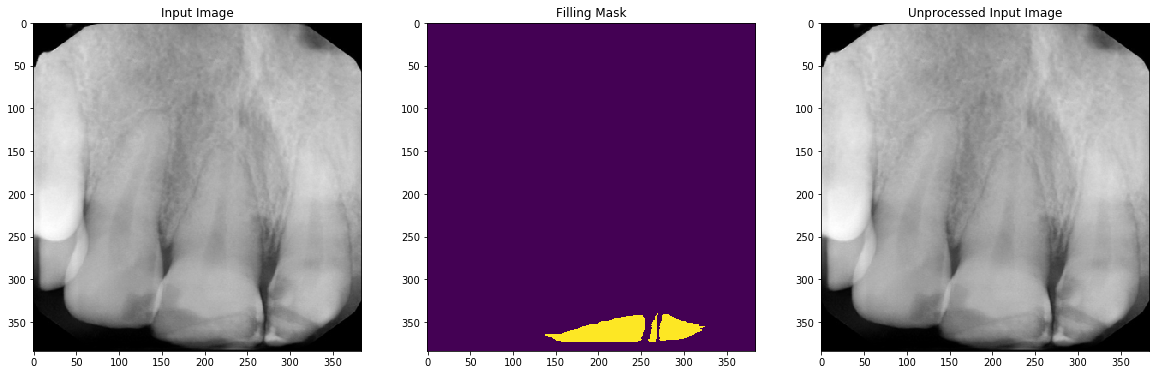

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959612510.8515.70517682.7881377.60122.50..40/Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959612510.8515.70517682.7881377.60122.50..40/Anterior2MaxillaR/filling-composite.jpg']


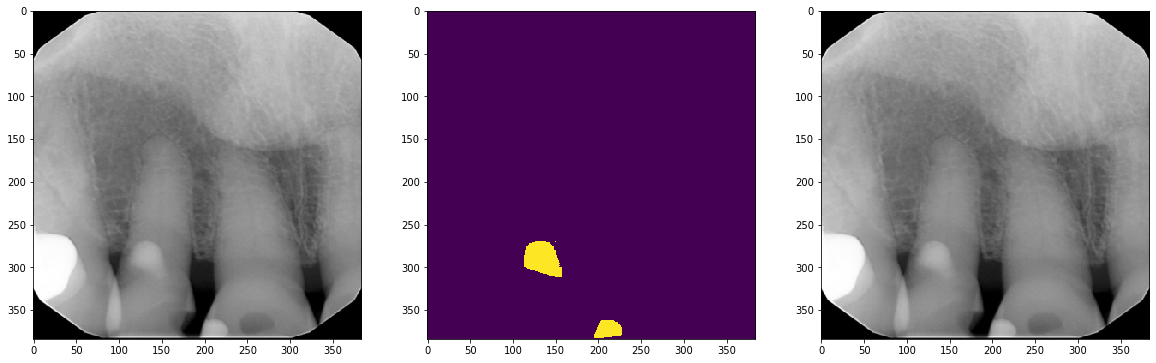

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959.17606.120671417768267.176777855117500720/Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959.17606.120671417768267.176777855117500720/Anterior2MaxillaR/filling-composite.jpg']


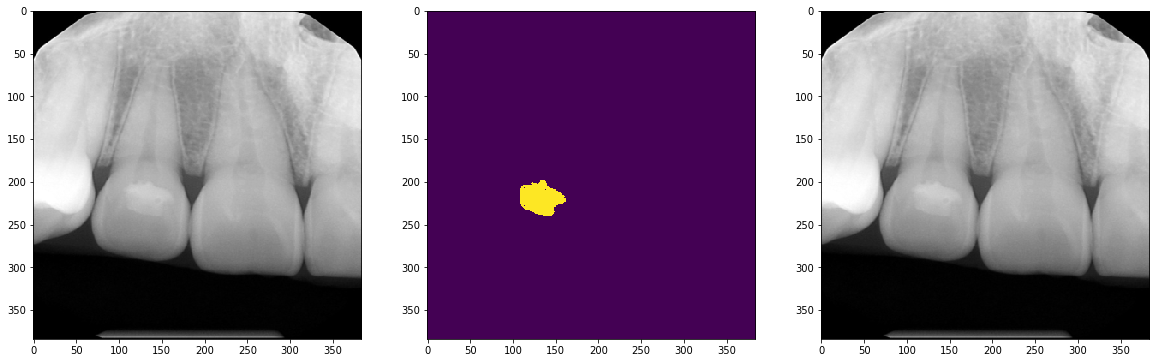

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.959.06782135.00473.76826.5.66.74147.11705135/Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.959.06782135.00473.76826.5.66.74147.11705135/Anterior2MaxillaR/filling-metal.jpg']


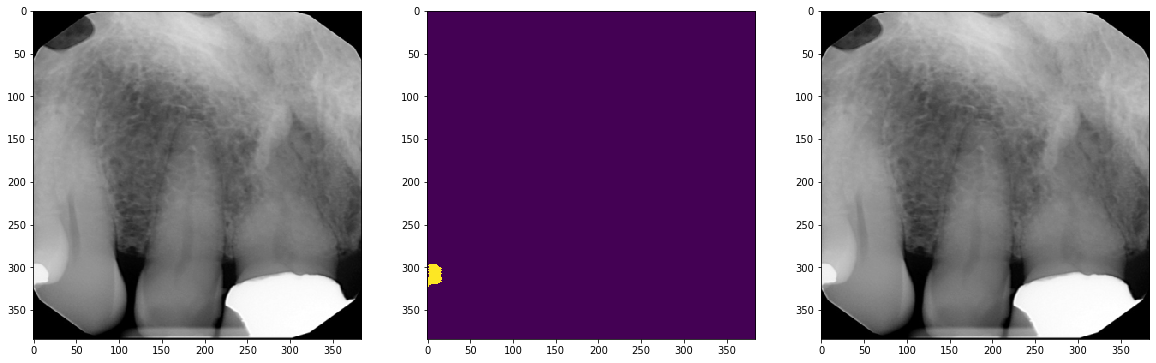

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.9596023730277702.55768207570477703.2.5174751/Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.9596023730277702.55768207570477703.2.5174751/Anterior2MaxillaR/filling-composite.jpg']


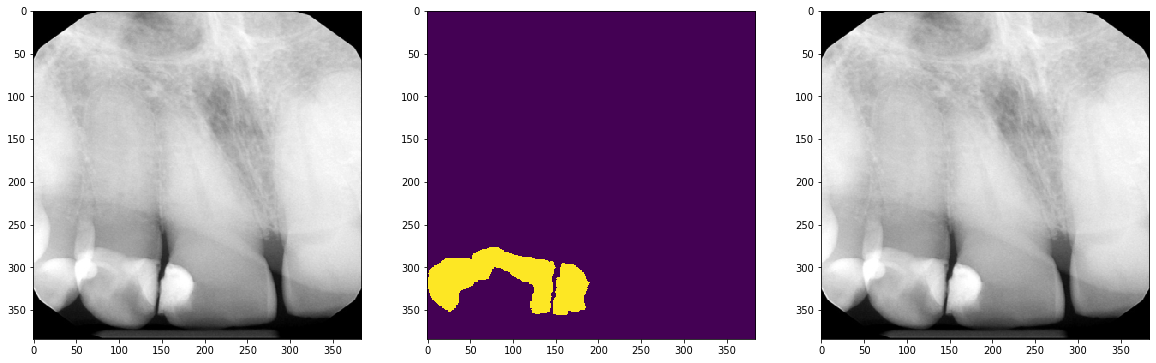

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.9591581565031064.027682.03445777508750.0505./Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.9591581565031064.027682.03445777508750.0505./Anterior2MaxillaR/filling-metal.jpg', '/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.9591581565031064.027682.03445777508750.0505./Anterior2MaxillaR/filling-composite.jpg']


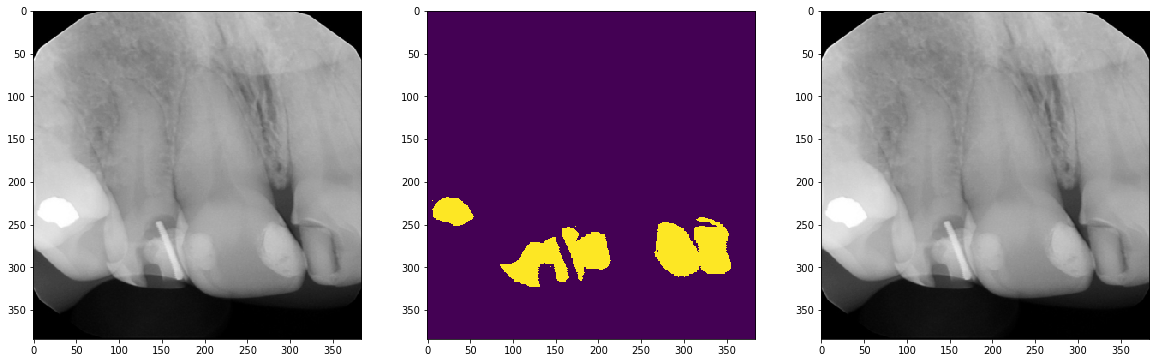

/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.9590..26002662.00567682.030347702.1.1730082./Anterior2MaxillaR/4/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.9590..26002662.00567682.030347702.1.1730082./Anterior2MaxillaR/4/filling-composite.jpg']


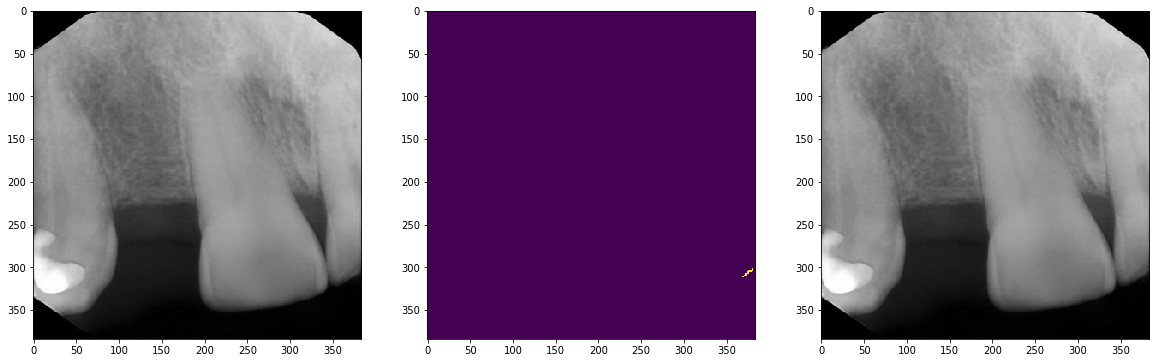

/home/rohan/Datasets/prior_clean/train/images/1.190926791160849.95907.2306.78511.8876826..017718081081788303/Anterior2MaxillaR/im.jpg
['/home/rohan/Datasets/prior_clean/train/masks/1.190926791160849.95907.2306.78511.8876826..017718081081788303/Anterior2MaxillaR/filling-composite.jpg']


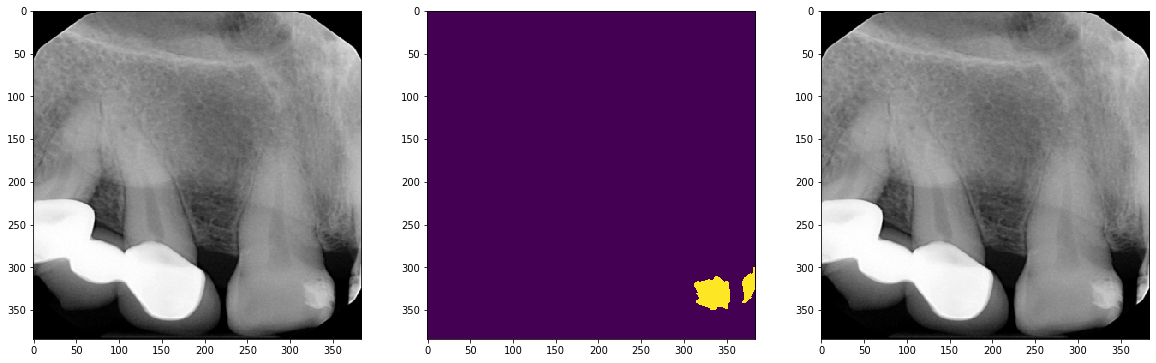

/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.959281..06.667027007682.18448771465618112456/Anterior2MaxillaR/1/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.959281..06.667027007682.18448771465618112456/Anterior2MaxillaR/1/filling-composite.jpg']


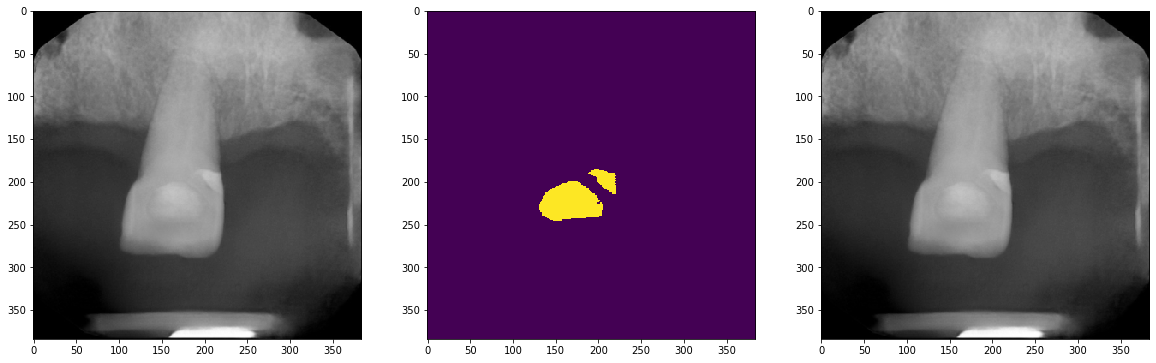

/home/rohan/Datasets/synthetic_prior_clean/train/images/1.190926791160849.95950421.0700686...76820748687710.815.27.230/Anterior2MaxillaR/0/im.jpg
['/home/rohan/Datasets/synthetic_prior_clean/train/masks/1.190926791160849.95950421.0700686...76820748687710.815.27.230/Anterior2MaxillaR/0/filling-composite.jpg']


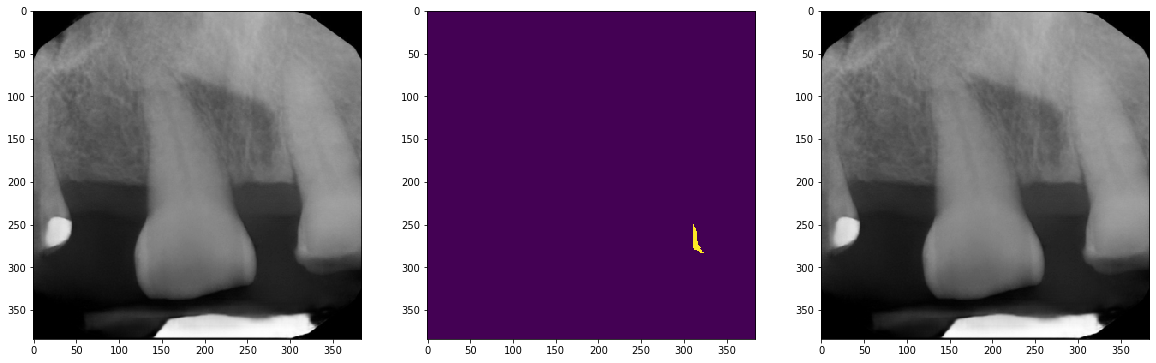

In [10]:
def get_sampler(dataset, shuffle=False):
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if shuffle :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    sampler = SequentialSampler(indices)
    
    return sampler
    
def plotter(ax, input_img, calculus_mask, image1, idx):
    
    ax[0].imshow(input_img, cmap='gray')
    ax[1].imshow(calculus_mask)
    ax[2].imshow(image1, cmap='gray')
#     ax[3].imshow(mask1)

    if idx==0:
        ax[0].set_title('Input Image')
        ax[1].set_title('Filling Mask')
        ax[2].set_title('Unprocessed Input Image')
#         ax[3].set_title('Unprocessed Mask')
    
def main():
    
    
    random_seed= 42
    mark4 = time.time()
    root_dir='/home/rohan/Datasets/prior_clean/train'
#     calculus_clean_train = CalculusBase(root_dir, oversample=2, label_filter=label_filter, issynthetic=False, test_size=0.1,im_range='all', isTrain=True)
    filling_clean_val = FillingBase(root_dir, oversample=2, oversample_filter=oversample_filter, issynthetic=False, test_size=0.1,im_range=[0,1000], isTrain=False)
    print('Real dataload time {:.6f}'.format(time.time() - mark4))

    mark3 = time.time()
    synth_root_dir='/home/rohan/Datasets/synthetic_prior_clean/train'
#     calculus_synthetic_train = CalculusBase(synth_root_dir, oversample=1, label_filter=label_filter, issynthetic=True, test_size=0.05,im_range='all', isTrain=True)
    filling_synthetic_val = FillingBase(synth_root_dir, oversample=1,oversample_filter=oversample_filter,  issynthetic=True, test_size=0.05,im_range=[0,1000], isTrain=False)
    print('Synthetic dataload time {:.6f}'.format(time.time() - mark3))
    
    teeth_dataset = RetraceSynthDataLoader(filling_clean_val,
                                           filling_synthetic_val,
                                  image_size=(384,384),
                                  length = 'all',# pass 'all' for all
                                  crop = True,
                                  transform=None)
    i=0
    for data in teeth_dataset:
        if i<10:
            if 1. in data['masks']:
                
                f, ax = plt.subplots(1, 3, figsize=(20,30))
                print(data['path'])
                print(data['filling_path'])
#                 ipdb.set_trace()
                plotter(ax,data['image'][0,:,:],data['masks'][0,:,:],data['image1'][0,:,:],i)
                plt.show()
                i +=1
        else:
            break;
    
            
        
        
        
            
main()